# IPython Notebook for animation

## Importing the required libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import display, clear_output
import  matplotlib.animation as animation
import scipy.optimize as opt

## Set the path/ filename of the file the contains the data

In [2]:
inputfilePath = 'config_output.txt'
#obsfilePath = 'obs_output.txt'
obsfilePath = 'params_out/out12.txt'

## Read the data from the files and save it in lists of floats

In [3]:
e = 1.602176634*1e-19
hbar = 1.054571817*1e-34

plotData = [] #Array to save the real part of the wave functions
with open(inputfilePath,'r') as inputfile:
    for line in inputfile:
        plotData.append(line.strip().split('\t')) #Tab is used as seperator between values
    for j in range(len(plotData)): #Cast list items from string to float type
        plotData[j] = [float(plotData[j][i]) for i in range(len(plotData[0]))] # cast entries to float
    plotData = np.array(plotData) # cast to numpy array
    
obsData = [] # Array to save the observable data
with open(obsfilePath,'r') as obsfile:
    for line in obsfile:
        obsData.append(line.strip().split('\t'))
    for j in range(len(obsData)):
        obsData[j] = [float(obsData[j][i]) for i in range(len(obsData[0]))]
    obsData = np.array(obsData).T

## Graphical output of the observables

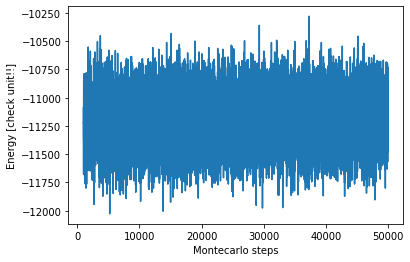

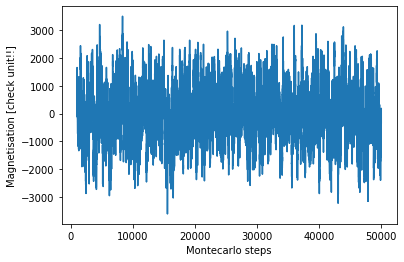

In [4]:
# %matplotlib qt5
#n_th = 200
n_th = 1000

plt.plot(obsData[0][n_th:],obsData[1][n_th:])
plt.xlabel("Montecarlo steps")
plt.ylabel("Energy [check unit!!]")
plt.show()
    
plt.plot(obsData[0][n_th:],obsData[2][n_th:])
plt.xlabel("Montecarlo steps")
plt.ylabel("Magnetisation [check unit!!]")
plt.show()

In [5]:
energyNoTherm = np.array(obsData[1][n_th:])

In [6]:
def auto_corr(obs, N, k, mu):
    return sum((obs[:N-k] - mu) * (obs[k:] - mu))/(N-k)

def exp_fit(x,a,tau):
    return a*np.exp(-x/tau)

In [7]:
autocorr = []
k_max = 2500
k_array = np.arange(k_max)
energy_expect = np.mean(energyNoTherm)
for k in k_array:
    autocorr.append(auto_corr(energyNoTherm, len(energyNoTherm), k, energy_expect))
autocorr = autocorr/auto_corr(energyNoTherm, len(energyNoTherm), 0, energy_expect)

In [8]:
#integrated autocorrelation time
tau_int=sum(autocorr)
tau_int

3.9290156431991012

In [9]:
#autocorrelation time with fit
fit = opt.curve_fit(exp_fit,k_array,autocorr[:],p0=(1,5))[0]
A = fit[0]
tau = fit[1]
tau

4.856533916500021

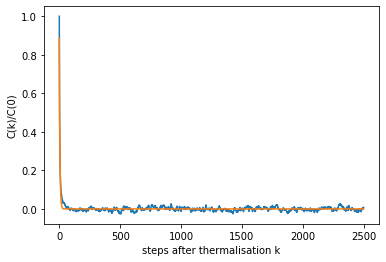

In [10]:
#%matplotlib qt5
plt.plot(k_array[:k_max],autocorr[:k_max])
plt.plot(k_array[:k_max], A * np.exp(-k_array[:k_max]/tau))
plt.xlabel("steps after thermalisation k")
plt.ylabel("C(k)/C(0)")
plt.show()

In [11]:
N_eff = len(energyNoTherm)/(2*tau)
print("Energy expectation value: (%.1f +- %.1f) e.u."%(energy_expect,np.std(energyNoTherm)/np.sqrt(N_eff)))

Energy expectation value: (-11199.2 +- 2.8) e.u.


In [14]:
%matplotlib qt5
beta = [0.1, 0.3, 0.5, 0.7]
B = [0., 0.01, 0.03]
obsfilePath_list = ['params_out/out'+str(st)+'.txt' for st in range(12)]

fig, axs = plt.subplots(4, 3)
for i in range(4):
    for j in range(3):
        obsData = importObsData(obsfilePath_list[i*3+j])
        #makeEnergyPlot(obsData)
        axs[i, j].plot(obsData[0][:],obsData[1][:])
        axs[i, j].set_title('beta = %e, B = %e'%(beta[i],B[j])) 

NameError: name 'importObsData' is not defined

## Analytic Calculation of the Hamiltonian
$$H(s)=-\sum_{<xy>}s(x)s(y)-B\sum_x s(x)$$
1. system with all spins up s_1:\
The product $s(x)s(y)$ always takes a value 1 and there are N * D summands. The second sum has N summands which all add -B:
$H(s_1)=-N*D-N*B$
 
2. system with all spins down s_2:\
The product $s(x)s(y)$ always takes a value 1 and there are N * D summands. The second sum has N summands which all add +B:
$H(s_2)=-N*D+N*B$
 
3. system with alternating orientation of spins in index notation s_3:\
Every spin with an even index has a up position, every spin with a odd index has a down position. The next neighbours of spin with index i, s(i), are s(i+N^µ) with µ=0,...,D-1.\
case 1: N is even\
If N is even, every exponential N^µ is even, except for µ=0 where it is 1. So every product $s(x)s(y)$ except for µ=0 is a product between spins with even indeces or spins with odd indeces and is therefore 1, but the product with the next neighbour with µ=0 is -1. The first sum in $H(s)$ is therefore -N * (D-2). For even N there as many spin ups as there are spin downs and therefore the second sum equals zero:\
$H(s_3,N\ even)=-N*(D-2)$ \
case 2: N is odd\
If N is odd, every exponential N^µ is odd. So every product $s(x)s(y)$ is a product between two spins with one even index and one odd index is therefore -1. The first sum in $H(s)$ is therefore N * D. For odd N there is one more even index and therefore the second sum delivers -B:\
$H(s_3,N\ odd)=N*D-B$

## Generate animation

In [13]:
fps = 5
nSeconds = int(len(plotData)/fps)

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(100,100) )

plotData = plotData.reshape(len(plotData),100,100)
im = plt.imshow(plotData[0], interpolation='none', aspect='auto', vmin=0, vmax=1)

def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(plotData[i])
    return [im]

anim = animation.FuncAnimation(fig, animate_func, frames = nSeconds * fps, interval = 1000 / fps)

anim.save('test_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

print('Done!')

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


..........

ValueError: unknown file extension: .mp4